In [2]:
import warnings
#warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import collections

In [3]:
STAT_COLUMNS = [
    'st', 'carav', 'g', 
    'cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int',
    'rush_att', 'rush_yds', 'rush_tds',
    'rec', 'rec_yds', 'rec_tds', 'tkl',
    'def_int'
]

POSITION_DEPENDENT_FEATURES = [
    'cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int', 'rush_att', 'rush_yds', 'rush_tds', 'rec', 'rec_yds', 'rec_tds', 'tkl', 'def_int', 'sk', 
]


In [4]:
# import and preview dataset
data = pd.read_csv("nfl_draft.csv")
data.head()

column_a player_id  year  rnd  pick   tm           player hof  \
0   2015Jameis Winston  WinsJa00  2015    1     1  TAM   Jameis Winston  No   
1   2015Marcus Mariota  MariMa01  2015    1     2  TEN   Marcus Mariota  No   
2     2015Dante Fowler  FowlDa00  2015    1     3  JAX     Dante Fowler  No   
3     2015Amari Cooper  CoopAm00  2015    1     4  OAK     Amari Cooper  No   
4  2015Brandon Scherff  ScheBr00  2015    1     5  WAS  Brandon Scherff  No   

   pos position_standard  ...  rush_att  rush_yds  rush_tds    rec  rec_yds  \
0   QB                QB  ...      86.0     311.0       7.0    NaN      NaN   
1   QB                QB  ...      79.0     516.0       4.0    1.0     41.0   
2  OLB                LB  ...       NaN       NaN       NaN    NaN      NaN   
3   WR                WR  ...       3.0      -3.0       0.0  134.0   1970.0   
4    T                 T  ...       NaN       NaN       NaN    NaN      NaN   

   rec_tds   tkl  def_int   sk  college_univ  
0      NaN   NaN      NaN  NaN   Florida St.  
1      1.0   NaN      NaN  NaN        Oregon  
2      NaN  16.0      NaN  2.5       Florida  
3      9.0   NaN      NaN  NaN       Alabama  
4      NaN   NaN      NaN  NaN          Iowa  

[5 rows x 34 columns]

In [5]:
# frequency of null entries in each feature
data.isnull().sum()

column_a                0
player_id            1219
year                    0
rnd                     0
pick                    0
tm                      0
player                  0
hof                     0
pos                     0
position_standard       0
first4av                0
age                  1245
to                   1382
ap1                     0
pb                      0
st                      0
carav                1382
drav                 2165
g                    1415
cmp                  7841
pass_att             7841
pass_yds             7841
pass_td              7841
pass_int             7841
rush_att             6789
rush_yds             6789
rush_tds             6789
rec                  6264
rec_yds              6264
rec_tds              6264
tkl                  4324
def_int              6819
sk                   4388
college_univ         3430
dtype: int64

In [6]:
#Many features have null values. We suspect that the reason is that some
#positions do not do things that other positions do. For example, a linebacker
#will likely never throw a football, so they will have null for cmp
#(completions)

#let's verify and check how many QB's have null completions vs total amount of
#null completions
null_cmps = data[data['cmp'].isnull()]
null_cmps


column_a player_id  year  rnd  pick   tm            player  \
2         2015Dante Fowler  FowlDa00  2015    1     3  JAX      Dante Fowler   
3         2015Amari Cooper  CoopAm00  2015    1     4  OAK      Amari Cooper   
4      2015Brandon Scherff  ScheBr00  2015    1     5  WAS   Brandon Scherff   
5     2015Leonard Williams  WillLe02  2015    1     6  NYJ  Leonard Williams   
6          2015Kevin White  WhitKe00  2015    1     7  CHI       Kevin White   
...                    ...       ...   ...  ...   ...  ...               ...   
8430      1985Raymond Polk       NaN  1985   12   332  RAI      Raymond Polk   
8431     1985Paul Woodside       NaN  1985   12   333  BUF     Paul Woodside   
8432         1985Dan Lynch       NaN  1985   12   334  DEN         Dan Lynch   
8433         1985Ray Noble       NaN  1985   12   335  MIA         Ray Noble   
8434    1985Donald Chumley       NaN  1985   12   336  SFO    Donald Chumley   

     hof  pos position_standard  ...  rush_att  rush_yds  rush_tds    rec  \
2     No  OLB                LB  ...       NaN       NaN       NaN    NaN   
3     No   WR                WR  ...       3.0      -3.0       0.0  134.0   
4     No    T                 T  ...       NaN       NaN       NaN    NaN   
5     No   DE                DE  ...       NaN       NaN       NaN    NaN   
6     No   WR                WR  ...       1.0       9.0       0.0   19.0   
...   ..  ...               ...  ...       ...       ...       ...    ...   
8430  No   DB                DB  ...       NaN       NaN       NaN    NaN   
8431  No    K                 K  ...       NaN       NaN       NaN    NaN   
8432  No    G                 G  ...       NaN       NaN       NaN    NaN   
8433  No   DB                DB  ...       NaN       NaN       NaN    NaN   
8434  No   DT                DT  ...       NaN       NaN       NaN    NaN   

      rec_yds  rec_tds   tkl  def_int              sk   college_univ  
2         NaN      NaN  16.0      NaN             2.5        Florida  
3      1970.0      9.0   NaN      NaN             NaN        Alabama  
4         NaN      NaN   NaN      NaN             NaN           Iowa  
5         NaN      NaN  56.0      NaN               9            USC  
6       187.0      0.0   NaN      NaN             NaN  West Virginia  
...       ...      ...   ...      ...             ...            ...  
8430      NaN      NaN   NaN      NaN    Oklahoma St.            NaN  
8431      NaN      NaN   NaN      NaN   West Virginia            NaN  
8432      NaN      NaN   NaN      NaN  Washington St.            NaN  
8433      NaN      NaN   NaN      NaN      California            NaN  
8434      NaN      NaN   NaN      NaN         Georgia            NaN  

[7841 rows x 34 columns]

In [7]:
null_cmps.loc[null_cmps['pos'] == 'QB']

# as we can see, very few QB positions have null values for cmp while many non
# QB positions do. Because of this, we think it is best to impute a value of 0 
# for the position-dependent features completions, rush attempts, touchdowns, 
# etc) 

column_a player_id  year  rnd  pick   tm           player  \
74    2015Garrett Grayson  GrayGa00  2015    3    75  NOR  Garrett Grayson   
418      2014Aaron Murray  MurrAa00  2014    5   163  KAN     Aaron Murray   
438       2014David Fales  FaleDa00  2014    6   183  CHI      David Fales   
449     2014Keith Wenning  WennKe00  2014    6   194  BAL    Keith Wenning   
468         2014Tajh Boyd  BoydTa00  2014    6   213  NYJ        Tajh Boyd   
...                   ...       ...   ...  ...   ...  ...              ...   
8330   1985Steve Calabria       NaN  1985    9   232  TAM   Steve Calabria   
8332      1985Paul Berner       NaN  1985    9   234  SDG      Paul Berner   
8367      1985Buddy Funck       NaN  1985   10   269  DEN      Buddy Funck   
8375      1985John Conner       NaN  1985   10   277  SEA      John Conner   
8392       1985Joe Shield  ShieJo20  1985   11   294  GNB       Joe Shield   

     hof pos position_standard  ...  rush_att  rush_yds  rush_tds  rec  \
74    No  QB                QB  ...       NaN       NaN       NaN  NaN   
418   No  QB                QB  ...       NaN       NaN       NaN  NaN   
438   No  QB                QB  ...       NaN       NaN       NaN  NaN   
449   No  QB                QB  ...       NaN       NaN       NaN  NaN   
468   No  QB                QB  ...       NaN       NaN       NaN  NaN   
...   ..  ..               ...  ...       ...       ...       ...  ...   
8330  No  QB                QB  ...       NaN       NaN       NaN  NaN   
8332  No  QB                QB  ...       NaN       NaN       NaN  NaN   
8367  No  QB                QB  ...       NaN       NaN       NaN  NaN   
8375  No  QB                QB  ...       NaN       NaN       NaN  NaN   
8392  No  QB                QB  ...       NaN       NaN       NaN  NaN   

      rec_yds  rec_tds  tkl  def_int            sk  college_univ  
74        NaN      NaN  NaN      NaN           NaN  Colorado St.  
418       NaN      NaN  NaN      NaN           NaN       Georgia  
438       NaN      NaN  NaN      NaN           NaN  San Jose St.  
449       NaN      NaN  NaN      NaN           NaN      Ball St.  
468       NaN      NaN  NaN      NaN           NaN       Clemson  
...       ...      ...  ...      ...           ...           ...  
8330      NaN      NaN  NaN      NaN       Colgate           NaN  
8332      NaN      NaN  NaN      NaN       Pacific           NaN  
8367      NaN      NaN  NaN      NaN    New Mexico           NaN  
8375      NaN      NaN  NaN      NaN       Arizona           NaN  
8392      NaN      NaN  NaN      NaN  Trinity (CT)           NaN  

[115 rows x 34 columns]

In [8]:
data[POSITION_DEPENDENT_FEATURES] = data[POSITION_DEPENDENT_FEATURES].fillna(0)
data.isnull().sum()

column_a                0
player_id            1219
year                    0
rnd                     0
pick                    0
tm                      0
player                  0
hof                     0
pos                     0
position_standard       0
first4av                0
age                  1245
to                   1382
ap1                     0
pb                      0
st                      0
carav                1382
drav                 2165
g                    1415
cmp                     0
pass_att                0
pass_yds                0
pass_td                 0
pass_int                0
rush_att                0
rush_yds                0
rush_tds                0
rec                     0
rec_yds                 0
rec_tds                 0
tkl                     0
def_int                 0
sk                      0
college_univ         3430
dtype: int64

In [9]:
data['position_standard'].value_counts()
#LS is a specialized version of C, so we can combine the two into the same position


DB    1569
LB    1124
WR    1049
RB     809
DE     731
DT     640
T      619
G      542
TE     496
QB     398
C      225
K       78
FB      77
P       77
LS       1
Name: position_standard, dtype: int64

In [10]:
data['position_standard'] = data['position_standard'].replace(['LS'], 'C')
data['position_standard'].value_counts()

DB    1569
LB    1124
WR    1049
RB     809
DE     731
DT     640
T      619
G      542
TE     496
QB     398
C      226
K       78
FB      77
P       77
Name: position_standard, dtype: int64

In [11]:
print(data['rnd'].corr(data['drav']))
print(data['rnd'].corr(data['carav']))
print(data['drav'].corr(data['carav']))


#drav and carav basically describe the same thing (career average and draft
#average)
#this can be seen from their correlation value
#we decide to drop drav because corr with rnd lower than carav and they are similar
data[['st', 'g', 'cmp', 'pass_att',
       'pass_yds', 'pass_td', 'pass_int', 'rush_att', 'rush_yds', 'rush_tds',
       'rec', 'rec_yds', 'rec_tds', 'tkl', 'def_int', 'sk']].head()

-0.36528440711228094
-0.3756977577406549
0.8715160708472572


st     g    cmp  pass_att  pass_yds  pass_td  pass_int  rush_att  rush_yds  \
0   2  26.0  540.0     913.0    6722.0     42.0      25.0      86.0     311.0   
1   2  23.0  458.0     725.0    5590.0     42.0      18.0      79.0     516.0   
2   0  10.0    0.0       0.0       0.0      0.0       0.0       0.0       0.0   
3   1  26.0    0.0       0.0       0.0      0.0       0.0       3.0      -3.0   
4   2  27.0    0.0       0.0       0.0      0.0       0.0       0.0       0.0   

   rush_tds    rec  rec_yds  rec_tds   tkl  def_int   sk  
0       7.0    0.0      0.0      0.0   0.0      0.0    0  
1       4.0    1.0     41.0      1.0   0.0      0.0    0  
2       0.0    0.0      0.0      0.0  16.0      0.0  2.5  
3       0.0  134.0   1970.0      9.0   0.0      0.0    0  
4       0.0    0.0      0.0      0.0   0.0      0.0    0

In [12]:
def transform(x):
  if(x['year'] <= 1993): #rounds before 1993 did not have 32 rounds per pick. We should standardize to today's standard
    x['rnd'] = 1 + int(x['pick'] / 32)
  return x

data = data.apply(func=transform, axis=1, result_type='broadcast')



In [13]:
data.loc[data['rnd'] <= 3, 'rnd'] = 1
data.loc[(data['rnd'] > 3) & (data['rnd'] <= 6) , 'rnd'] = 4
data.loc[data['rnd'] > 6, 'rnd'] = 7
data

column_a player_id  year rnd pick   tm           player hof  \
0      2015Jameis Winston  WinsJa00  2015   1    1  TAM   Jameis Winston  No   
1      2015Marcus Mariota  MariMa01  2015   1    2  TEN   Marcus Mariota  No   
2        2015Dante Fowler  FowlDa00  2015   1    3  JAX     Dante Fowler  No   
3        2015Amari Cooper  CoopAm00  2015   1    4  OAK     Amari Cooper  No   
4     2015Brandon Scherff  ScheBr00  2015   1    5  WAS  Brandon Scherff  No   
...                   ...       ...   ...  ..  ...  ...              ...  ..   
8430     1985Raymond Polk       NaN  1985   7  332  RAI     Raymond Polk  No   
8431    1985Paul Woodside       NaN  1985   7  333  BUF    Paul Woodside  No   
8432        1985Dan Lynch       NaN  1985   7  334  DEN        Dan Lynch  No   
8433        1985Ray Noble       NaN  1985   7  335  MIA        Ray Noble  No   
8434   1985Donald Chumley       NaN  1985   7  336  SFO   Donald Chumley  No   

      pos position_standard  ... rush_att rush_yds rush_tds    rec rec_yds  \
0      QB                QB  ...     86.0    311.0      7.0    0.0     0.0   
1      QB                QB  ...     79.0    516.0      4.0    1.0    41.0   
2     OLB                LB  ...      0.0      0.0      0.0    0.0     0.0   
3      WR                WR  ...      3.0     -3.0      0.0  134.0  1970.0   
4       T                 T  ...      0.0      0.0      0.0    0.0     0.0   
...   ...               ...  ...      ...      ...      ...    ...     ...   
8430   DB                DB  ...      0.0      0.0      0.0    0.0     0.0   
8431    K                 K  ...      0.0      0.0      0.0    0.0     0.0   
8432    G                 G  ...      0.0      0.0      0.0    0.0     0.0   
8433   DB                DB  ...      0.0      0.0      0.0    0.0     0.0   
8434   DT                DT  ...      0.0      0.0      0.0    0.0     0.0   

     rec_tds   tkl def_int              sk college_univ  
0        0.0   0.0     0.0               0  Florida St.  
1        1.0   0.0     0.0               0       Oregon  
2        0.0  16.0     0.0             2.5      Florida  
3        9.0   0.0     0.0               0      Alabama  
4        0.0   0.0     0.0               0         Iowa  
...      ...   ...     ...             ...          ...  
8430     0.0   0.0     0.0    Oklahoma St.          NaN  
8431     0.0   0.0     0.0   West Virginia          NaN  
8432     0.0   0.0     0.0  Washington St.          NaN  
8433     0.0   0.0     0.0      California          NaN  
8434     0.0   0.0     0.0         Georgia          NaN  

[8435 rows x 34 columns]

In [14]:
labels = data['rnd']

#pick directly correlates with round. keeping it as a feature would be data leakage
features = data.drop(['pick'], axis=1)
features.drop(['drav'], axis=1)
print(features.head())

              column_a player_id  year rnd   tm           player hof  pos  \
0   2015Jameis Winston  WinsJa00  2015   1  TAM   Jameis Winston  No   QB   
1   2015Marcus Mariota  MariMa01  2015   1  TEN   Marcus Mariota  No   QB   
2     2015Dante Fowler  FowlDa00  2015   1  JAX     Dante Fowler  No  OLB   
3     2015Amari Cooper  CoopAm00  2015   1  OAK     Amari Cooper  No   WR   
4  2015Brandon Scherff  ScheBr00  2015   1  WAS  Brandon Scherff  No    T   

  position_standard first4av  ... rush_att rush_yds rush_tds    rec rec_yds  \
0                QB       13  ...     86.0    311.0      7.0    0.0     0.0   
1                QB        9  ...     79.0    516.0      4.0    1.0    41.0   
2                LB        0  ...      0.0      0.0      0.0    0.0     0.0   
3                WR        9  ...      3.0     -3.0      0.0  134.0  1970.0   
4                 T        7  ...      0.0      0.0      0.0    0.0     0.0   

  rec_tds   tkl def_int   sk college_univ  
0     0.0   0.0   

In [15]:
print(data['rnd'])



0       1
1       1
2       1
3       1
4       1
       ..
8430    7
8431    7
8432    7
8433    7
8434    7
Name: rnd, Length: 8435, dtype: object


In [16]:
'''
Dropping ap1 (Deals with all pro designation), pb (Deals with Pro Bowler
designation), hof (hall of fame designation)
This is future data (received after they were drafted and cannot be used in
prediction)
'''
features = data.drop(['ap1', 'pb', 'to'], axis=1)

#unneeded  things like name/player id, team, etc. Does not help with our prediction
features.drop(['column_a','player_id','tm', 'hof', 'player', 'pos'], axis=1, inplace=True)

#drop things with too many nulls that cannot be imputed
features.drop(['college_univ'], axis=1, inplace=True)

print(features.columns)

Index(['year', 'rnd', 'pick', 'position_standard', 'first4av', 'age', 'st',
       'carav', 'drav', 'g', 'cmp', 'pass_att', 'pass_yds', 'pass_td',
       'pass_int', 'rush_att', 'rush_yds', 'rush_tds', 'rec', 'rec_yds',
       'rec_tds', 'tkl', 'def_int', 'sk'],
      dtype='object')


In [17]:
null_cmps.loc[null_cmps['pos'] == 'QB']

column_a player_id  year  rnd  pick   tm           player  \
74    2015Garrett Grayson  GrayGa00  2015    3    75  NOR  Garrett Grayson   
418      2014Aaron Murray  MurrAa00  2014    5   163  KAN     Aaron Murray   
438       2014David Fales  FaleDa00  2014    6   183  CHI      David Fales   
449     2014Keith Wenning  WennKe00  2014    6   194  BAL    Keith Wenning   
468         2014Tajh Boyd  BoydTa00  2014    6   213  NYJ        Tajh Boyd   
...                   ...       ...   ...  ...   ...  ...              ...   
8330   1985Steve Calabria       NaN  1985    9   232  TAM   Steve Calabria   
8332      1985Paul Berner       NaN  1985    9   234  SDG      Paul Berner   
8367      1985Buddy Funck       NaN  1985   10   269  DEN      Buddy Funck   
8375      1985John Conner       NaN  1985   10   277  SEA      John Conner   
8392       1985Joe Shield  ShieJo20  1985   11   294  GNB       Joe Shield   

     hof pos position_standard  ...  rush_att  rush_yds  rush_tds  rec  \
74    No  QB                QB  ...       NaN       NaN       NaN  NaN   
418   No  QB                QB  ...       NaN       NaN       NaN  NaN   
438   No  QB                QB  ...       NaN       NaN       NaN  NaN   
449   No  QB                QB  ...       NaN       NaN       NaN  NaN   
468   No  QB                QB  ...       NaN       NaN       NaN  NaN   
...   ..  ..               ...  ...       ...       ...       ...  ...   
8330  No  QB                QB  ...       NaN       NaN       NaN  NaN   
8332  No  QB                QB  ...       NaN       NaN       NaN  NaN   
8367  No  QB                QB  ...       NaN       NaN       NaN  NaN   
8375  No  QB                QB  ...       NaN       NaN       NaN  NaN   
8392  No  QB                QB  ...       NaN       NaN       NaN  NaN   

      rec_yds  rec_tds  tkl  def_int            sk  college_univ  
74        NaN      NaN  NaN      NaN           NaN  Colorado St.  
418       NaN      NaN  NaN      NaN           NaN       Georgia  
438       NaN      NaN  NaN      NaN           NaN  San Jose St.  
449       NaN      NaN  NaN      NaN           NaN      Ball St.  
468       NaN      NaN  NaN      NaN           NaN       Clemson  
...       ...      ...  ...      ...           ...           ...  
8330      NaN      NaN  NaN      NaN       Colgate           NaN  
8332      NaN      NaN  NaN      NaN       Pacific           NaN  
8367      NaN      NaN  NaN      NaN    New Mexico           NaN  
8375      NaN      NaN  NaN      NaN       Arizona           NaN  
8392      NaN      NaN  NaN      NaN  Trinity (CT)           NaN  

[115 rows x 34 columns]

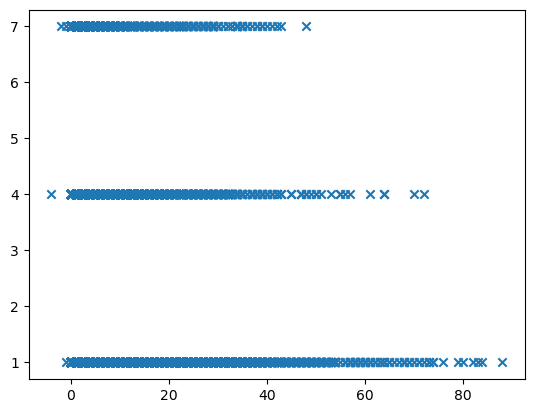

In [18]:
features[['first4av', 'rnd']]
plt.scatter(x=features['first4av'], y=features['rnd'], marker='x')

In [19]:
one_hot = pd.get_dummies(features['position_standard'])
combined = pd.concat([one_hot, features], axis=1).drop(['sk', 'position_standard'], axis=1)
features = combined.fillna(0)

In [20]:
# use counter to get frequency of each label
frequency = collections.Counter(labels)

# printing the frequency to view any class imbalances between the rounds
print(dict(frequency))

{1: 2996, 4: 3265, 7: 2174}


In [21]:
# print(features.columns)
# pd.set_option("display.max.columns", None)
# features[features.isin(['Washington']).any(axis=1)]

#for some reason sk - sacks - contains strings. change these to 0
# features['sk']
features = features.drop(['rnd', 'pick'], axis=1)

In [22]:
labels = labels.astype('int')

In [23]:
# features.head()
features.columns

Index(['C', 'DB', 'DE', 'DT', 'FB', 'G', 'K', 'LB', 'P', 'QB', 'RB', 'T', 'TE',
       'WR', 'year', 'first4av', 'age', 'st', 'carav', 'drav', 'g', 'cmp',
       'pass_att', 'pass_yds', 'pass_td', 'pass_int', 'rush_att', 'rush_yds',
       'rush_tds', 'rec', 'rec_yds', 'rec_tds', 'tkl', 'def_int'],
      dtype='object')

In [24]:
# for i in range(len(features.columns)):
#     print(features.iloc[0, i])

copy = features[['st', 'carav', 'g', 
    'cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int',
    'rush_att', 'rush_yds', 'rush_tds',
    'rec', 'rec_yds', 'rec_tds', 'tkl',
    'def_int', 'first4av']]
out = pd.concat([copy, labels], axis = 1)
out2 = pd.concat([features, labels], axis = 1)
out.corr()

st     carav         g       cmp  pass_att  pass_yds  \
st        1.000000  0.927256  0.839346  0.199028  0.198151  0.199435   
carav     0.927256  1.000000  0.854450  0.275431  0.273642  0.276759   
g         0.839346  0.854450  1.000000  0.143586  0.143241  0.144347   
cmp       0.199028  0.275431  0.143586  1.000000  0.998297  0.999309   
pass_att  0.198151  0.273642  0.143241  0.998297  1.000000  0.998067   
pass_yds  0.199435  0.276759  0.144347  0.999309  0.998067  1.000000   
pass_td   0.199427  0.279005  0.145254  0.990224  0.983926  0.991511   
pass_int  0.192087  0.261200  0.139884  0.973472  0.981722  0.974245   
rush_att  0.176371  0.281866  0.179850  0.127332  0.128572  0.127915   
rush_yds  0.174139  0.283023  0.177339  0.107919  0.109931  0.108866   
rush_tds  0.176718  0.283631  0.174632  0.150759  0.152321  0.152057   
rec       0.334085  0.369160  0.345307 -0.027318 -0.027847 -0.026884   
rec_yds   0.324784  0.358375  0.326457 -0.025827 -0.026315 -0.025419   
rec_tds   0.314530  0.335396  0.307358 -0.022800 -0.023252 -0.022435   
tkl       0.434391  0.431331  0.419072 -0.035663 -0.036737 -0.035523   
def_int   0.353192  0.365266  0.331825 -0.023614 -0.024240 -0.023520   
first4av  0.836477  0.903878  0.758364  0.201971  0.201498  0.203129   
rnd      -0.389991 -0.399619 -0.398567 -0.073812 -0.074798 -0.073469   

           pass_td  pass_int  rush_att  rush_yds  rush_tds       rec  \
st        0.199427  0.192087  0.176371  0.174139  0.176718  0.334085   
carav     0.279005  0.261200  0.281866  0.283023  0.283631  0.369160   
g         0.145254  0.139884  0.179850  0.177339  0.174632  0.345307   
cmp       0.990224  0.973472  0.127332  0.107919  0.150759 -0.027318   
pass_att  0.983926  0.981722  0.128572  0.109931  0.152321 -0.027847   
pass_yds  0.991511  0.974245  0.127915  0.108866  0.152057 -0.026884   
pass_td   1.000000  0.950358  0.127522  0.107811  0.151468 -0.023248   
pass_int  0.950358  1.000000  0.125485  0.106849  0.147175 -0.027664   
rush_att  0.127522  0.125485  1.000000  0.994661  0.960460  0.310878   
rush_yds  0.107811  0.106849  0.994661  1.000000  0.962449  0.315454   
rush_tds  0.151468  0.147175  0.960460  0.962449  1.000000  0.288625   
rec      -0.023248 -0.027664  0.310878  0.315454  0.288625  1.000000   
rec_yds  -0.022334 -0.026113  0.185894  0.191971  0.171662  0.980998   
rec_tds  -0.019861 -0.023048  0.097787  0.104288  0.093097  0.929594   
tkl      -0.032859 -0.038351 -0.059148 -0.057151 -0.055470 -0.083002   
def_int  -0.021916 -0.025101 -0.040857 -0.039791 -0.038212 -0.061600   
first4av  0.201777  0.193341  0.307996  0.309688  0.309788  0.347711   
rnd      -0.069605 -0.075544 -0.131976 -0.130302 -0.125101 -0.178193   

           rec_yds   rec_tds       tkl   def_int  first4av       rnd  
st        0.324784  0.314530  0.434391  0.353192  0.836477 -0.389991  
carav     0.358375  0.335396  0.431331  0.365266  0.903878 -0.399619  
g         0.326457  0.307358  0.419072  0.331825  0.758364 -0.398567  
cmp      -0.025827 -0.022800 -0.035663 -0.023614  0.201971 -0.073812  
pass_att -0.026315 -0.023252 -0.036737 -0.024240  0.201498 -0.074798  
pass_yds -0.025419 -0.022435 -0.035523 -0.023520  0.203129 -0.073469  
pass_td  -0.022334 -0.019861 -0.032859 -0.021916  0.201777 -0.069605  
pass_int -0.026113 -0.023048 -0.038351 -0.025101  0.193341 -0.075544  
rush_att  0.185894  0.097787 -0.059148 -0.040857  0.307996 -0.131976  
rush_yds  0.191971  0.104288 -0.057151 -0.039791  0.309688 -0.130302  
rush_tds  0.171662  0.093097 -0.055470 -0.038212  0.309788 -0.125101  
rec       0.980998  0.929594 -0.083002 -0.061600  0.347711 -0.178193  
rec_yds   1.000000  0.962971 -0.075818 -0.056485  0.332706 -0.169183  
rec_tds   0.962971  1.000000 -0.066924 -0.050421  0.306989 -0.156529  
tkl      -0.075818 -0.066924  1.000000  0.275345  0.423649 -0.234225  
def_int  -0.056485 -0.050421  0.275345  1.000000  0.314746 -0.150429  
first4av  0.332706  0.306989  0.423649  0.314746  1.000000 -0.455143  


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
params = {"max_depth": [5,10,15,20], "min_samples_leaf": [5,10,15,20]}
grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy') #inner loop
# replace clf with grid_search if you want to test parameters
nested_score = cross_val_score(grid_search, copy, labels, cv=5, error_score='raise') #outer loop
print("Accuracy:", nested_score.mean()*100)

Accuracy: 54.22643746295199


In [26]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
scores = cross_val_score(clf, copy, labels, cv=10)                                       
print("Accuracy:", scores.mean()*100)

# #Alternative (cross_val_predict instead of cross_val_score) to analyze the results in more detail:
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# clf = GaussianNB()
# predicts = cross_val_predict(clf, features, labels, cv=10) 
# print("Predictions:", predicts) 
# print("Confusion Matrix:\n", confusion_matrix(labels, predicts))
# print("Report:\n", classification_report(labels, predicts))

Accuracy: 39.19466417050367


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
scaler = StandardScaler()
pca = PCA()
neigh = KNeighborsClassifier()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('KNN', neigh)])

param_grid = {
    'pca__n_components': list(range(5, 19)),
    'KNN__n_neighbors': list(range(1, 25))
}

grid_search = GridSearchCV(pipe, param_grid, cv=5)

nested_score = cross_val_score(grid_search, copy, labels, cv=5)
print("Accuracy:", nested_score.mean()*100)

c:\Users\lawso\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\lawso\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Accuracy: 53.360995850622416


c:\Users\lawso\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('svc', SVC())])
param_grid = {
    'pca__n_components': list(range(5, 6)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5)
predicts = cross_val_predict(grid_search, copy, labels, cv=10)

print("Accuracy:", ((labels==predicts).sum())/len(labels))
print("Report:\n", classification_report(labels, predicts))

Accuracy: 0.5131001778304682
Report:
               precision    recall  f1-score   support

           1       0.64      0.61      0.62      2996
           4       0.45      0.77      0.57      3265
           7       0.00      0.00      0.00      2174

    accuracy                           0.51      8435
   macro avg       0.36      0.46      0.40      8435
weighted avg       0.40      0.51      0.44      8435



c:\Users\lawso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lawso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lawso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('MLP', MLPClassifier())])
param_grid = {
    'MLP__hidden_layer_sizes': list(range(30, 70, 10)),
    'MLP__activation': ['logistic', 'tanh', 'relu']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5)
nested_score = cross_val_score(grid_search, copy, labels, cv=5)
print("Accuracy:", nested_score.mean()*100)